In [1]:
%matplotlib inline
%config InlineBackend.figure_format='retina'

In [14]:
import numpy as np
import matplotlib.pyplot as plt
import os
import sys
import time

import numpy as np
import h5py

from matplotlib import mlab
from matplotlib import gridspec
from scipy.interpolate import interp1d

from scipy.signal import hilbert, medfilt
from copy import deepcopy

import seaborn as sns
sns.set(style="white", palette="muted", color_codes=True)

# Read in a real waveform

In [3]:
waveforms = dict()
for dist in ['0100_0300', '0250_0500', '0400_0800', '0700_1200']:
    
    with h5py.File('../data/waveforms/waveforms_3s_{}.h5'.format(dist)) as file:
        waveforms_ = np.array(file['waveforms'])
        failed_ = np.array(file['failed'])
        waveforms[dist] = np.array([waveforms_[i] for i in range(len(waveforms_)) if i not in failed_])

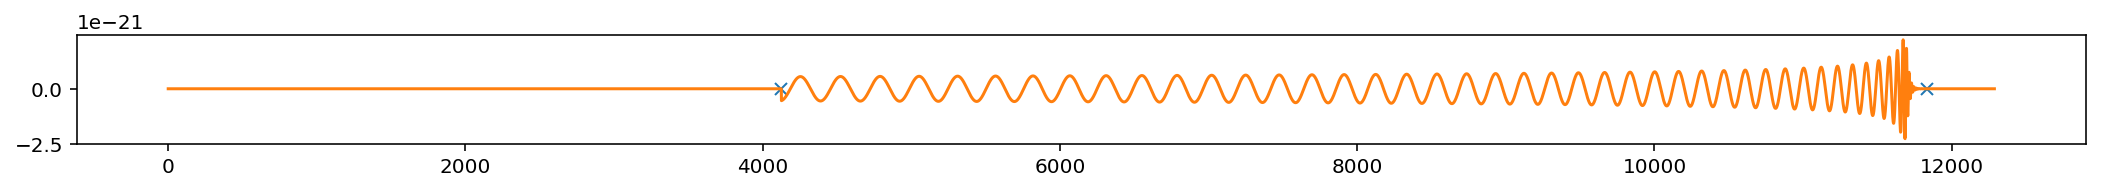

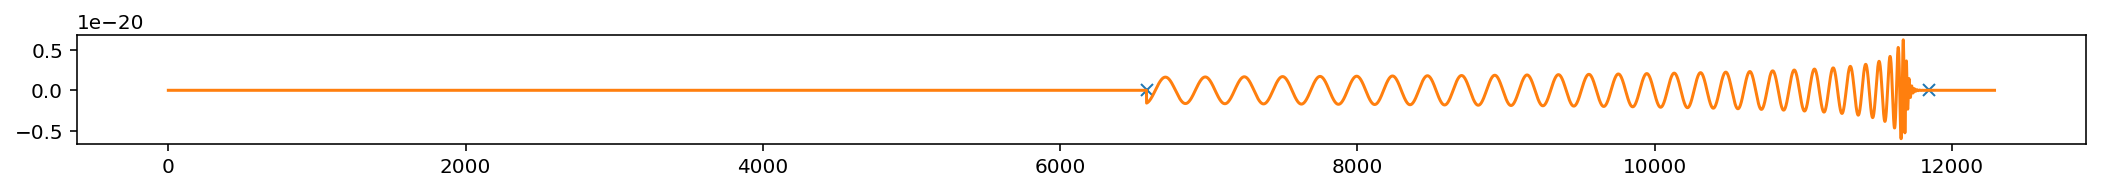

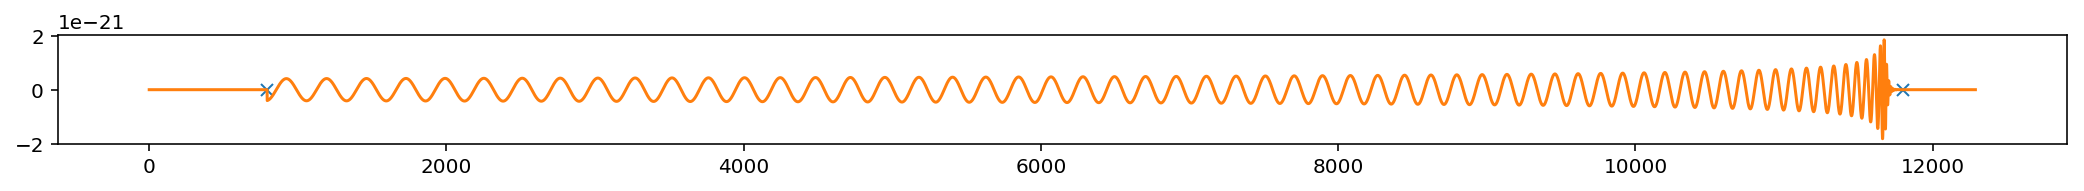

In [4]:
def get_start_end_idx(waveform):

    start = None
    end = None
    for j in range(len(waveform)):
        if waveform[j] != 0:
            start = j
            break
    for j in range(len(waveform))[::-1]:
        if waveform[j] != 0:
            end = j
            break
    
    return start, end


# Plot some of the loudest waveforms, just for fun
for i in range(3):
    
    waveform = waveforms['0100_0300'][i]
    
    start, end = get_start_end_idx(waveform)
    plt.plot([start, end], [0, 0], 'x')
    
    plt.plot(waveform)
    plt.gcf().set_size_inches(18, 1, forward=True)
    plt.show()

In [5]:
def get_envelope(signal):
    
    # Pad the signal with zeros at the beginning and end to reduce edge effects
    padded_signal = np.pad(signal, 100, 'constant', constant_values=0)
    
    # Calculate the raw envelope using the Hilbert transformation
    analytic_signal = hilbert(padded_signal)
    amplitude_envelope = np.abs(analytic_signal)

    # Smoothen the envelope using a median filter and a rolling average
    smooth = amplitude_envelope
    smooth[0:200] = medfilt(smooth[0:200], kernel_size=25)
    smooth = np.convolve(smooth, np.ones(10), mode='same') / 10
    
    # Remove the zero padding again to match the original signal length
    result = smooth[100:-100]
    
    return result

## Get the FWHM of the signal envelope

DISTANCE: 0100_0300
Mean: 254.6 ± 92.2
Percentiles (25%/50%/75%): 194.2 / 258.0 / 310.0


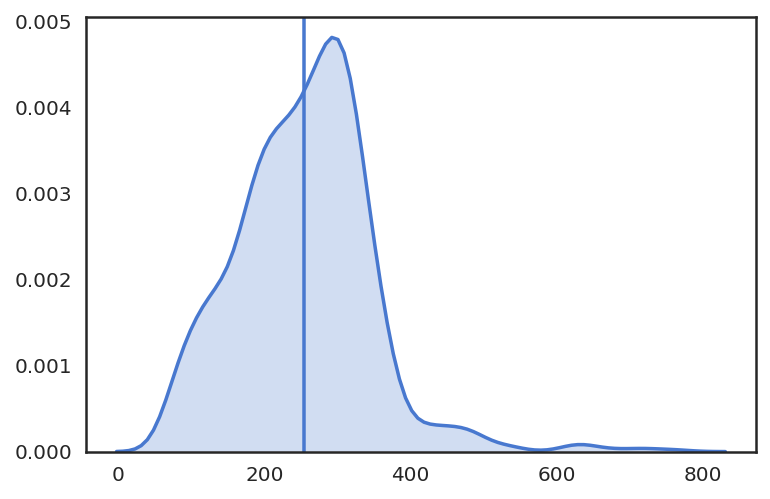

-------------------------------------------------------------------------------
DISTANCE: 0250_0500
Mean: 255.3 ± 92.8
Percentiles (25%/50%/75%): 192.0 / 259.0 / 315.0


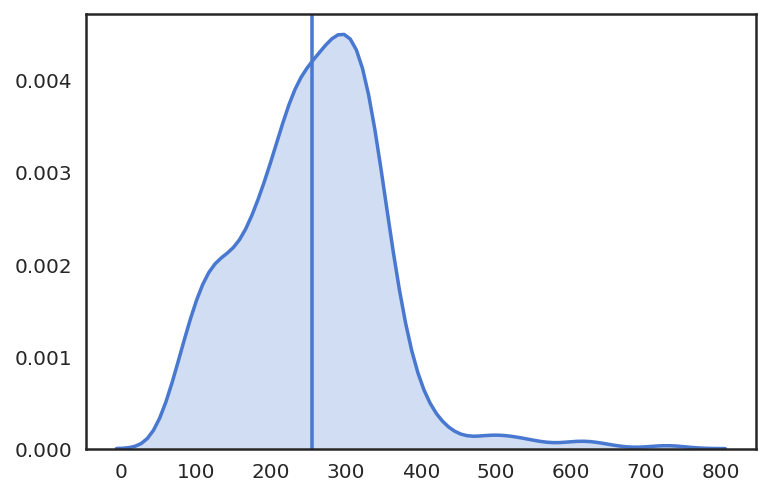

-------------------------------------------------------------------------------
DISTANCE: 0400_0800
Mean: 256.8 ± 88.0
Percentiles (25%/50%/75%): 190.0 / 262.0 / 316.0


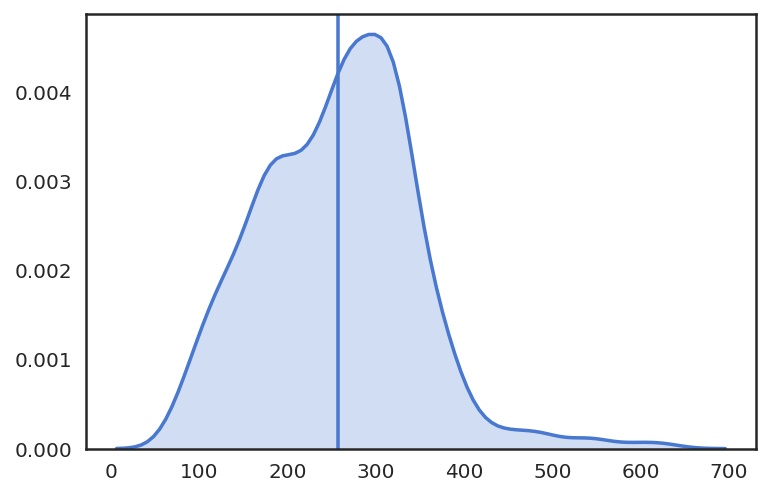

-------------------------------------------------------------------------------
DISTANCE: 0700_1200
Mean: 256.6 ± 89.3
Percentiles (25%/50%/75%): 195.0 / 263.0 / 315.0


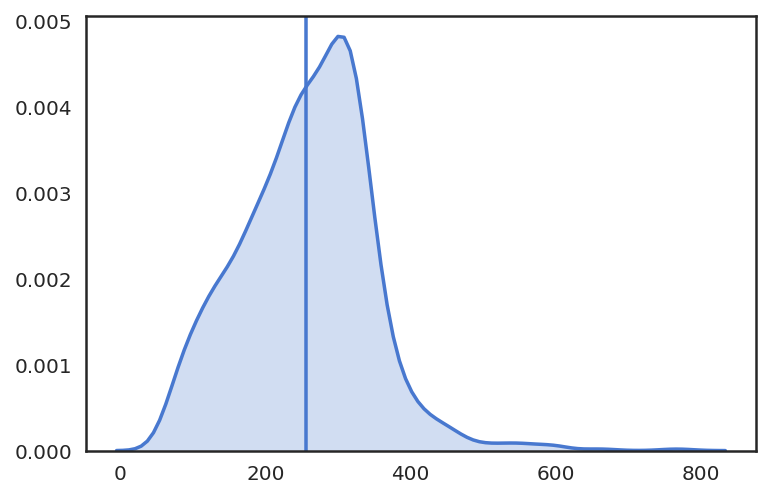

-------------------------------------------------------------------------------


In [20]:
for dist in ['0100_0300', '0250_0500', '0400_0800', '0700_1200']:

    print('DISTANCE: {}'.format(dist))
    
    FWHMs = []
    for i in range(len(waveforms[dist])):

        waveform = waveforms[dist][i]
        start, end = get_start_end_idx(waveform)
        waveform = waveform[start:end]
        envelope = get_envelope(waveform)

        maximum = np.max(envelope)
        FWHM = []
        for j in range(len(envelope)):
            if envelope[j] > 0.5*maximum:
                FWHM.append(j)

        FWHMs.append(len(FWHM))
        
    print('Mean: {:.1f} ± {:.1f}'.format(np.mean(FWHMs), np.std(FWHMs)))
    print('Percentiles (25%/50%/75%): {:.1f} / {:.1f} / {:.1f}'.format(np.percentile(FWHMs, 25), np.percentile(FWHMs, 50), np.percentile(FWHMs, 75)))
    sns.distplot(FWHMs, hist=False, kde_kws={"shade": True})
    plt.axvline(x=np.mean(FWHMs))
    plt.show()
    
    print(79*'-')

## Calculate percentiles of all these waveforms

In [38]:
percentiles_25 = {'0100_0300': [], '0250_0500': [], '0400_0800': [], '0700_1200': []}
percentiles_50 = {'0100_0300': [], '0250_0500': [], '0400_0800': [], '0700_1200': []}
percentiles_75 = {'0100_0300': [], '0250_0500': [], '0400_0800': [], '0700_1200': []}

for dist in ['0100_0300', '0250_0500', '0400_0800', '0700_1200']:
    
    for idx in range(len(waveforms[dist])):
    
        start, end = get_start_end_idx(waveforms[dist][idx])
        signal = waveforms[dist][idx][start:end]
        envelope = 10**21 * get_envelope(signal)
    
        percentiles_25[dist].append(np.percentile(envelope, 25))
        percentiles_50[dist].append(np.percentile(envelope, 50))
        percentiles_75[dist].append(np.percentile(envelope, 75))

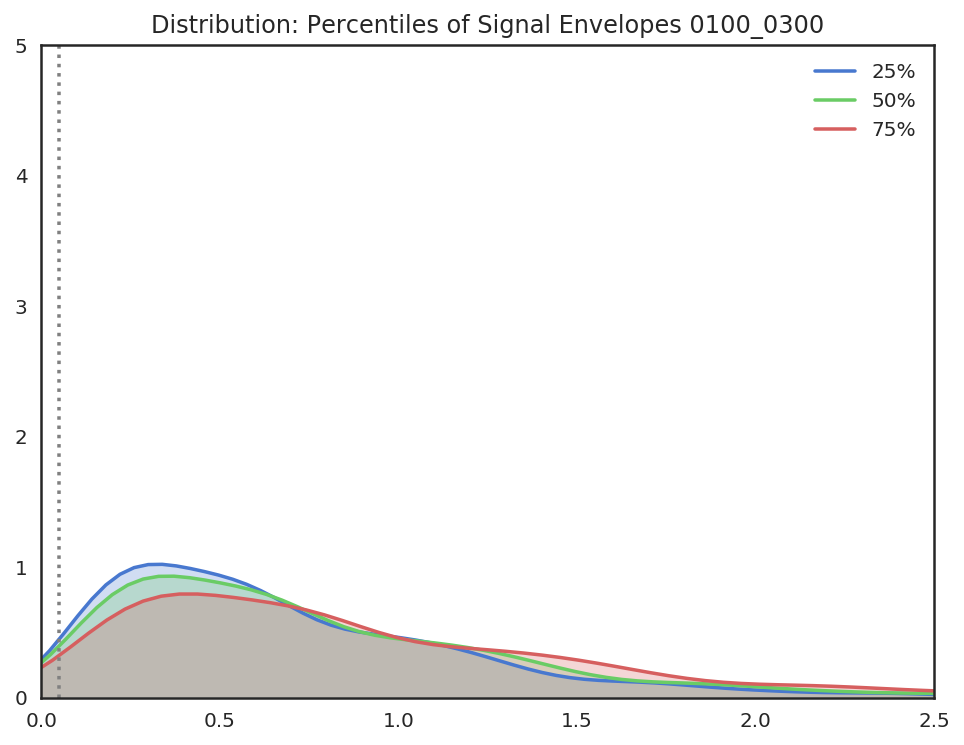

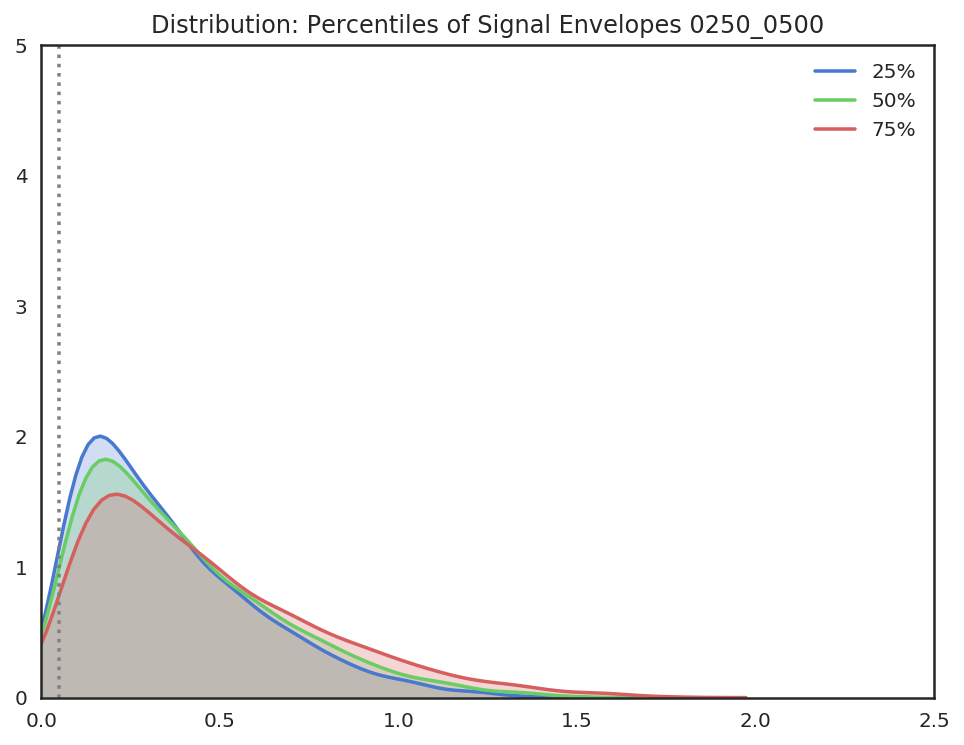

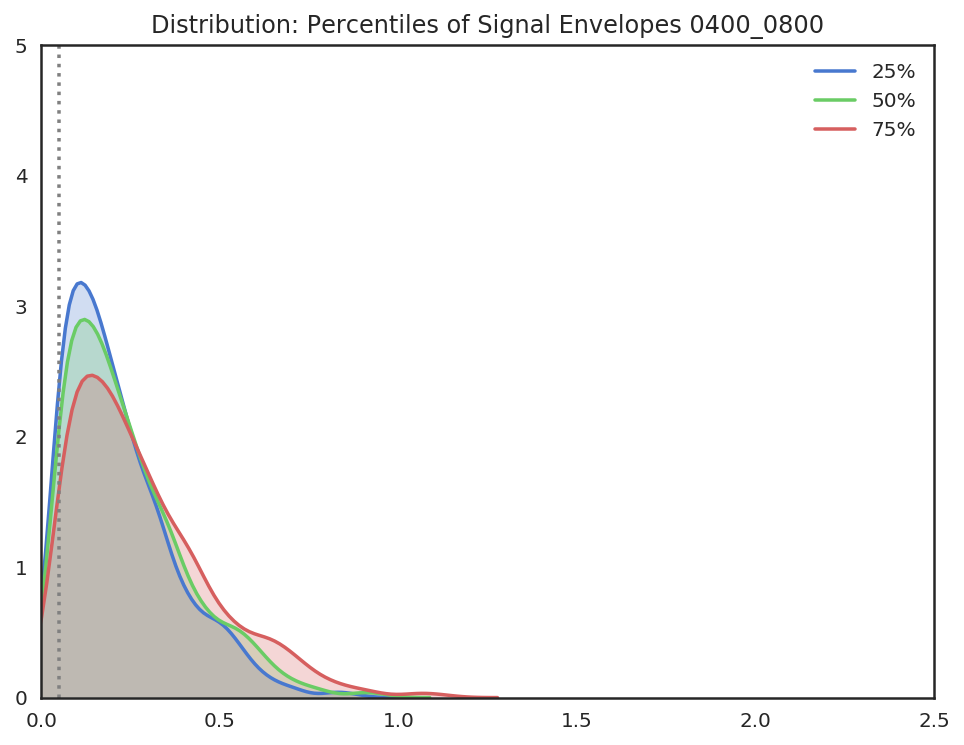

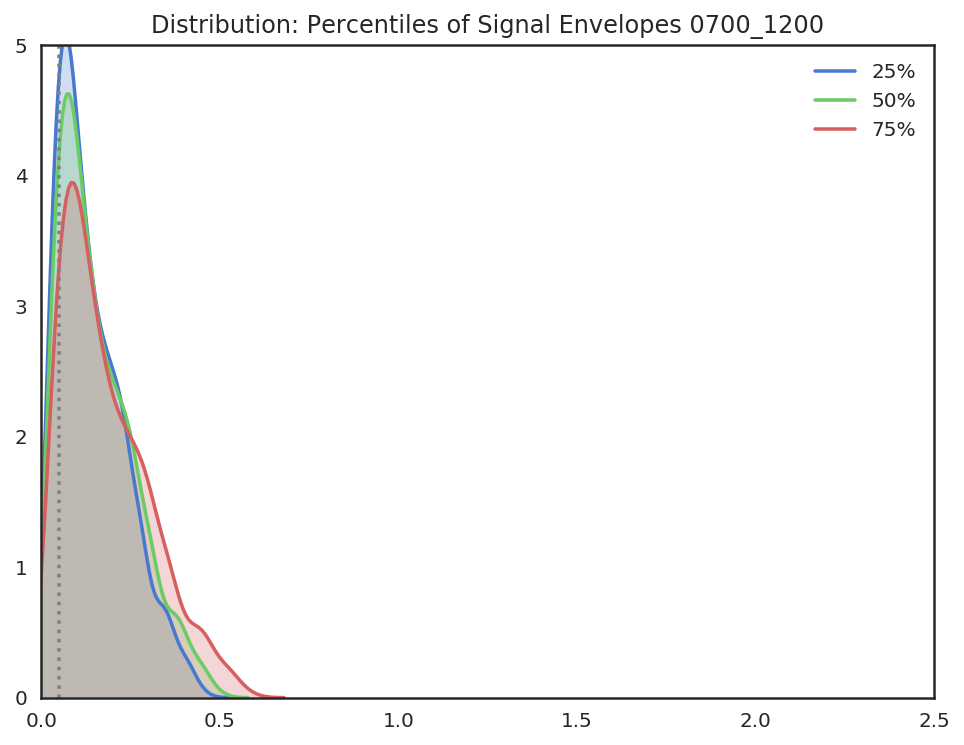

In [55]:
for dist in ['0100_0300', '0250_0500', '0400_0800', '0700_1200']:
    plt.title('Distribution: Percentiles of Signal Envelopes {}'.format(dist))
    sns.distplot(percentiles_25[dist], hist=False, kde_kws={"shade": True}, label='25%')
    sns.distplot(percentiles_50[dist], hist=False, kde_kws={"shade": True}, label='50%')
    sns.distplot(percentiles_75[dist], hist=False, kde_kws={"shade": True}, label='75%')
    plt.axvline(x=0.05, ls=':', color='Gray')
    plt.legend(loc='best')
    plt.xlim(0.0, 2.5)
    plt.ylim(0.0, 5)
    plt.gcf().set_size_inches(8, 6, forward=True)
    plt.show()
